In [3]:
import matplotlib.pyplot as plt, numpy as np, time
%matplotlib inline
from IPython import display

import torch, torch.nn as nn, torch.nn.functional as F

Redo the demo ([Example_linearvsRELUclassifier.ipynb)](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/Example_linearvsRELUclassifier.ipynb) using pytorch

In [4]:
n = 200 # number of points per class
k = 4 # number of classes
d = 2

rng = np.random.default_rng(1234) #for reproducibility

################################ some 4 color spiral training data
X_train = [[],[]] # 2d coords
for j in range(k): #classes
    r = np.linspace(1/n,1,n) # radius
    theta = np.linspace(j*2*np.pi/k, (j+3.5)*2*np.pi/k, n) + .2*rng.standard_normal(n) # .84*(2pi radians) = 301degs
    X_train[0] += list(r*np.cos(theta))
    X_train[1] += list(r*np.sin(theta))

X_train = np.array(X_train).T                            # nk x d array of data
y_train = np.array([[i]*n for i in range(k)]).flatten()  # nk list of classes

################################ some 4 color spiral test data
X_test = [[],[]] # 2d coords
#np.random.seed(1)
for j in range(k): #classes
    r = np.linspace(1/n,1,n) # radius
    theta = np.linspace(j*2*np.pi/k, (j+3.5)*2*np.pi/k, n) + .2*rng.standard_normal(n) # .84*(2pi radians) = 301degs
    X_test[0] += list(r*np.cos(theta))
    X_test[1] += list(r*np.sin(theta))

X_test = np.array(X_test).T                                  # nk x d array of data
y_test = np.array([[i]*n for i in range(k)]).flatten()  # nk list of classes

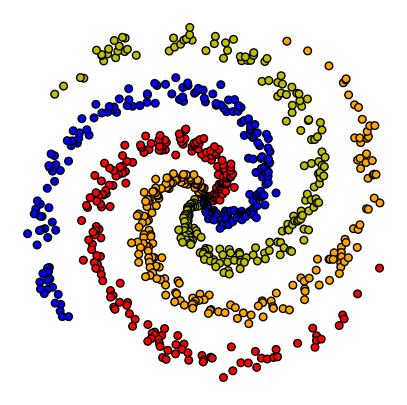

In [5]:
clrs = np.array(['r','orange','y','b'])

plt.figure(figsize=(5,5))
plt.scatter(*X_train.T, c=clrs[y_train], ec='k', s=30)
plt.axis(False);

In [6]:
torch.arange(0,1,.1)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In [7]:
torch.randn([3,5])

tensor([[-1.6150, -1.0303, -1.4358, -1.1032, -0.6573],
        [ 0.9056, -0.5631,  0.0033,  1.6185,  2.1162],
        [-0.1590, -2.0246,  0.2708,  1.6570, -0.3065]])

In [8]:
#hit tab key for completions
# torch.

In [9]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test)

X_train.dtype, y_train.dtype

(torch.float32, torch.int64)

In [10]:
model4 = nn.Sequential(
  nn.Linear(2,100),   #100 node layer, fully connected
  nn.ReLU(),
  nn.Linear(100,4),   # connects to 4 node output layer
#  nn.Softmax(1) #not in pytorch
)

optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)

In [11]:
for name, param in model4.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2] if name.endswith('bias') else param[:2,:2]} \n")

Layer: 0.weight | Size: torch.Size([100, 2]) | Values : tensor([[ 0.7010,  0.2822],
        [-0.6280,  0.3876]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([100]) | Values : tensor([ 0.2975, -0.6763], grad_fn=<SliceBackward0>) 

Layer: 2.weight | Size: torch.Size([4, 100]) | Values : tensor([[-0.0463,  0.0864],
        [-0.0330, -0.0719]], grad_fn=<SliceBackward0>) 

Layer: 2.bias | Size: torch.Size([4]) | Values : tensor([-0.0533,  0.0128], grad_fn=<SliceBackward0>) 



In [ ]:
model4(X_train)

In [1]:
X_train.shape, model4(X_train).shape

NameError: name 'X_train' is not defined

In [ ]:
# hasn't been trained yet
y_pred = model4(X_train)
loss = F.cross_entropy(y_pred, y_train) #-log(probability of data)
loss

four equal probabilities $p_i=1/4$, then $S -\sum_{i=0}^3 p_i\log p_i = -\sum_{i=0}^3 {1\over4}\log{1\over 4}
= 4\cdot {1\over4}\log4 = \log 4$

In [ ]:
np.log(4)

In [ ]:
# use either of these to calculate accuracy score
(y_pred.argmax(1) == y_train).numpy().mean(), (y_pred.argmax(1) == y_train).float().mean().item()

In [ ]:
# one optimization step

optimizer.zero_grad()  #zero the input gradients
loss.backward()
optimizer.step()

y_pred = model4(X_train)
loss = F.cross_entropy(y_pred, y_train)

loss.item(), (y_pred.argmax(1) == y_train).numpy().mean()

In [ ]:
T = 500 # 500 steps
scores = []
for i in range(T):
    optimizer.zero_grad()  #zero the input gradients
    y_pred = model4(X_train)
    loss = F.cross_entropy(y_pred, y_train)
    loss.backward()
    optimizer.step()

loss.item(), (y_pred.argmax(1) == y_train).numpy().mean()

In [ ]:
.9975*800

In [ ]:
#some convenience plot functions
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))

def do_plot(X,y,ax,title=None):
    # plot resulting classifier
    Z = model4(torch.tensor(np.c_[xx.ravel(),yy.ravel()]).float())
    Z = Z.detach().numpy().argmax(1).reshape(xx.shape)
    
    if title: ax.set_title(title)
    ax.contourf(xx,yy,Z, cmap='Spectral')
    ax.scatter(*X.T, c=clrs[y], ec='k', s=30)
    ax.set(xlim=(-1,1), ylim=(-1,1), aspect='equal')
    ax.axis(False)
    
def do_plot_disp(X, y, ax, tsleep=0, title=None):
    ax.cla()
    do_plot(X,y,ax,title)
    display.display(fig) 
    display.clear_output(wait=True)
    time.sleep(tsleep) #was .2

In [ ]:
# was already trained, so reinitialize to watch it train:
model4 = nn.Sequential(
  nn.Linear(2,128),   #128 node layer, fully connected
  nn.ReLU(),
  nn.Linear(128,4),   # connects to 4 node output layer
#  nn.Softmax(1) #no softmax, cross-entropy in pytorch expects logits
)

optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)

In [ ]:
fig=plt.figure(figsize=(5,5))

T = 500
scores = []
for i in range(T):
    optimizer.zero_grad()  #zero the input gradients
    logits = model4(X_train)
    loss = F.cross_entropy(logits, y_train)
    y_pred = model4(X_train)
    nwrong = (y_pred.argmax(1) != y_train).sum().item()
    
    tr_score = torch.sum(y_pred.argmax(1) == y_train)/len(X_train)
    te_score = torch.sum(model4(X_test).argmax(1) == y_test)/len(X_test)
    scores.append([loss.item(), tr_score, te_score])
    
    if i<20 or i%10==0:
        t = f'iteration {i+1}, loss: {loss:.2f}, #wrong: {nwrong}'
        do_plot_disp(X_train, y_train, plt.gca(), .1 if i <20 else 0, t)
    loss.backward()
    optimizer.step()

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(10.9,5))
t = f'iteration {i+1}, training score: {scores[-1][1]:.4f}'
do_plot(X_train, y_train, ax[0],t)
t = f'iteration {i+1}, test score: {scores[-1][2]:.4f}'
do_plot(X_test, y_test, ax[1],t)

In [ ]:
795/800

In [ ]:
scores=np.array(scores)

plt.figure(figsize=(10,5))
plt.plot(scores.T[0], label = 'loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')
plt.grid('on')
#plt.yticks(np.arange(.3,1.01,.05))
plt.legend(loc='upper left');

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(scores.T[1], label='training score')
plt.plot(scores.T[2], label = 'test score')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.grid('on')
plt.yticks(np.arange(.3,1.01,.05))
plt.legend(loc='upper left');

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(scores.T[1], label='training score')
plt.plot(scores.T[2], label = 'test score')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.grid('on')
plt.yticks(np.arange(.3,1.01,.05))
plt.legend(loc='upper left')
plt.yticks(np.arange(.9,1.01,.01))
plt.ylim(.9,1.005);

In [ ]:
#taken from lec20 demo
x1_train = [-4.23356681, -3.45770474, -2.42322198, -1.49649784, -0.35425647,
             0.4216056 ,  1.26212284,  2.25350216,  3.58970905,  4.10695043]
y1_train = [-0.11934071, -0.66046626, -0.23838833,  0.72481513,  1.4932134,
             1.01702292, -0.17345327, -0.76869136, -0.61717621, -0.32496842]

In [ ]:
plt.figure(figsize=(5,10/3))
plt.plot(x1_train, y1_train, 'o');

In [ ]:
x1_train = torch.tensor(x1_train)[:,None].float()  #add dimension
y1_train = torch.tensor(y1_train).float()

In [ ]:
N = 16
model1 = nn.Sequential(
  nn.Linear(1,N),   #N node layer, fully connected
  nn.ReLU(),
  nn.Linear(N,1,bias=False),                         # connects to 4 node output layer
)

optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)

In [ ]:
#not trained
y_pred = model1(x1_train)
F.mse_loss(y_pred.T[0], y1_train).item()

In [ ]:
plt.title(f'{N=}, loss={loss.item():.5f}')
plt.plot(x1_train, y1_train, 'o');
plt.plot(torch.linspace(-5,5,101),
         model1(torch.linspace(-5,5,101)[:,None]).detach()[:,0]);

In [ ]:
optimizer.zero_grad()  #zero the input gradients
y_pred = model1(x1_train)
loss = F.mse_loss(y_pred.T[0], y1_train)
loss.backward()
optimizer.step()

In [ ]:
T = 500
losses = []
for i in range(T):
    optimizer.zero_grad()  #zero the input gradients
    y_pred = model1(x1_train)
    loss = F.mse_loss(y_pred.T[0], y1_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
loss.item()

In [ ]:
plt.title(f'{N=}, loss={loss.item():.5f}')
plt.plot(x1_train, y1_train, 'o');
plt.plot(torch.linspace(-5,5,101),
         model1(torch.linspace(-5,5,101)[:,None]).detach()[:,0]);

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(losses, label = 'loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid('on')
#plt.ylim(0,.01)
plt.legend(loc='upper left');

In [ ]:
np.log(2)

In [ ]:
np.log2(2)